<bound method NDFrame.head of               age   d18O
0        -16.5010 -9.500
1          0.0000 -9.660
2         19.9980 -9.580
3         38.2475 -9.500
4         56.4970 -9.330
...           ...    ...
8348  640277.6000 -8.855
8349  640520.9000 -9.140
8350  640766.5000 -9.059
8351  641014.4000 -9.343
8352  641264.4000 -9.338

[8353 rows x 2 columns]>
641264.4
-16.501


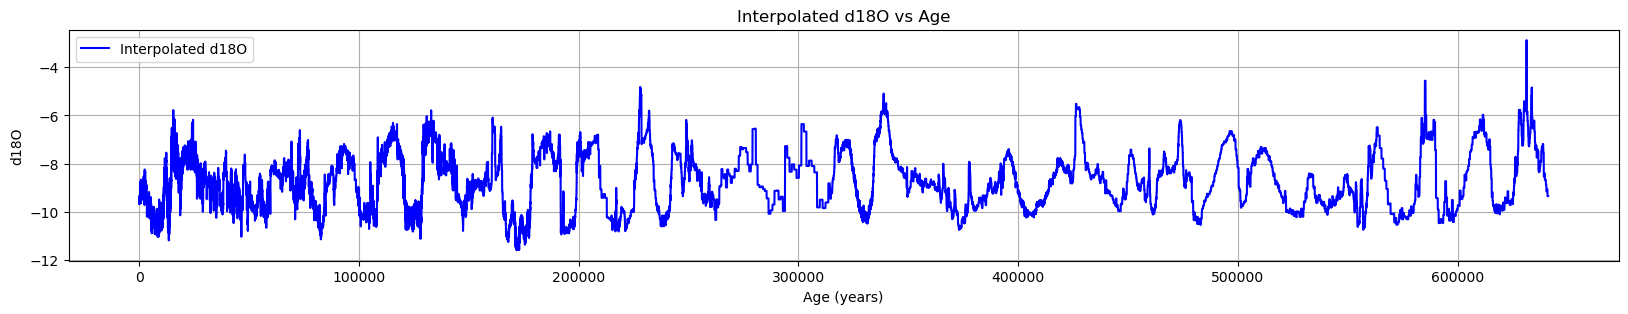

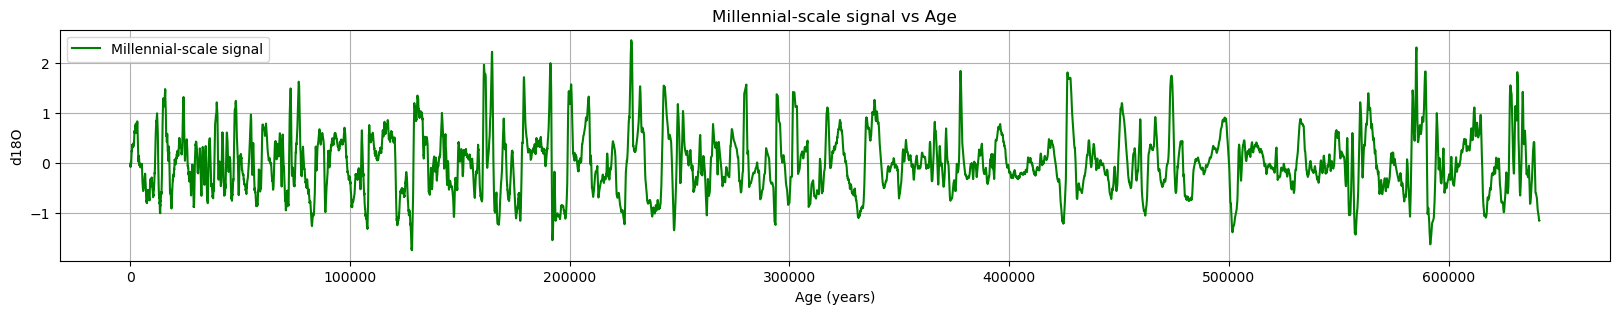

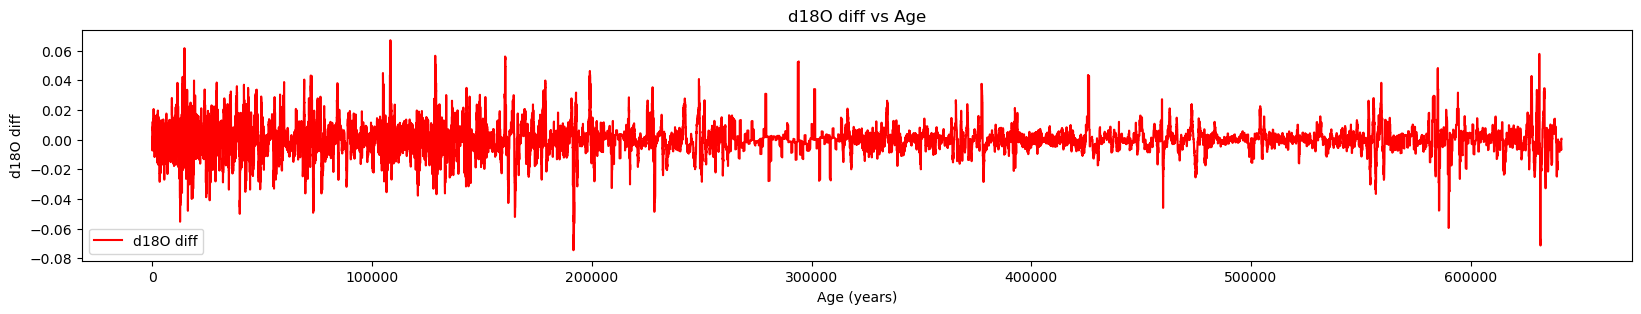

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

# path to your file
file_path = r"D:\VScode\bipolar_seesaw_CCM\other_data\monsoon.xlsx"

# read the first sheet into a DataFrame
df = pd.read_excel(file_path)
# age =age *1000
df['age'] = df['age'] * 1000

print(df.head)
# print the age max and min
print(df['age'].max())
print(df['age'].min())
# resample the data from age 0 to 641260 with a step of 10
new_age = np.arange(0, 641260, 10)
# create a new DataFrame with the new age values
f = interp1d(df['age'], df['d18O'], kind='nearest',
             bounds_error=False,
             fill_value=1)            

interpolated_sq = f(new_age)

# create a new DataFrame with the new age values
new_df = pd.DataFrame({'age': new_age, 'd18O': interpolated_sq})
# plot the data
plt.figure(figsize=(20, 3))
plt.plot(new_df['age'], new_df['d18O'], label='Interpolated d18O', color='blue')
plt.xlabel('Age (years)')
plt.ylabel('d18O')
plt.title('Interpolated d18O vs Age')
plt.legend()
plt.grid()
plt.show()


new_df["smoothed"] = new_df["d18O"].rolling(window=1000, center=True, min_periods=1).mean()

# 3) Millennial‐scale signal = original minus low‐frequency
new_df["d18O"] = new_df["d18O"] - new_df["smoothed"]

# smooth the millennial‐scale signal with a rolling mean 
new_df["d18O"] = new_df["d18O"].rolling(window=50, center=True, min_periods=1).mean()

# plot the smoothed data
plt.figure(figsize=(20, 3))
plt.plot(new_df['age'], new_df['d18O'], label='Millennial‐scale signal', color='green')
plt.xlabel('Age (years)')
plt.ylabel('d18O')
plt.title('Millennial‐scale signal vs Age')
plt.legend()
plt.grid()
plt.show()

# calculate the diff of d18O, and create a new DataFrame with the diff values
diff_d18O = np.diff(new_df['d18O'])
df_d18O_diff = pd.DataFrame({'age': new_df['age'].values[1:], 'd18O_diff': diff_d18O})

# plot the diff of d18O
plt.figure(figsize=(20, 3))
plt.plot(df_d18O_diff['age'], df_d18O_diff['d18O_diff'], label='d18O diff', color='red')
plt.xlabel('Age (years)')
plt.ylabel('d18O diff')
plt.title('d18O diff vs Age')
plt.legend()



Best threshold = gt -0.228,  F1 = 0.68


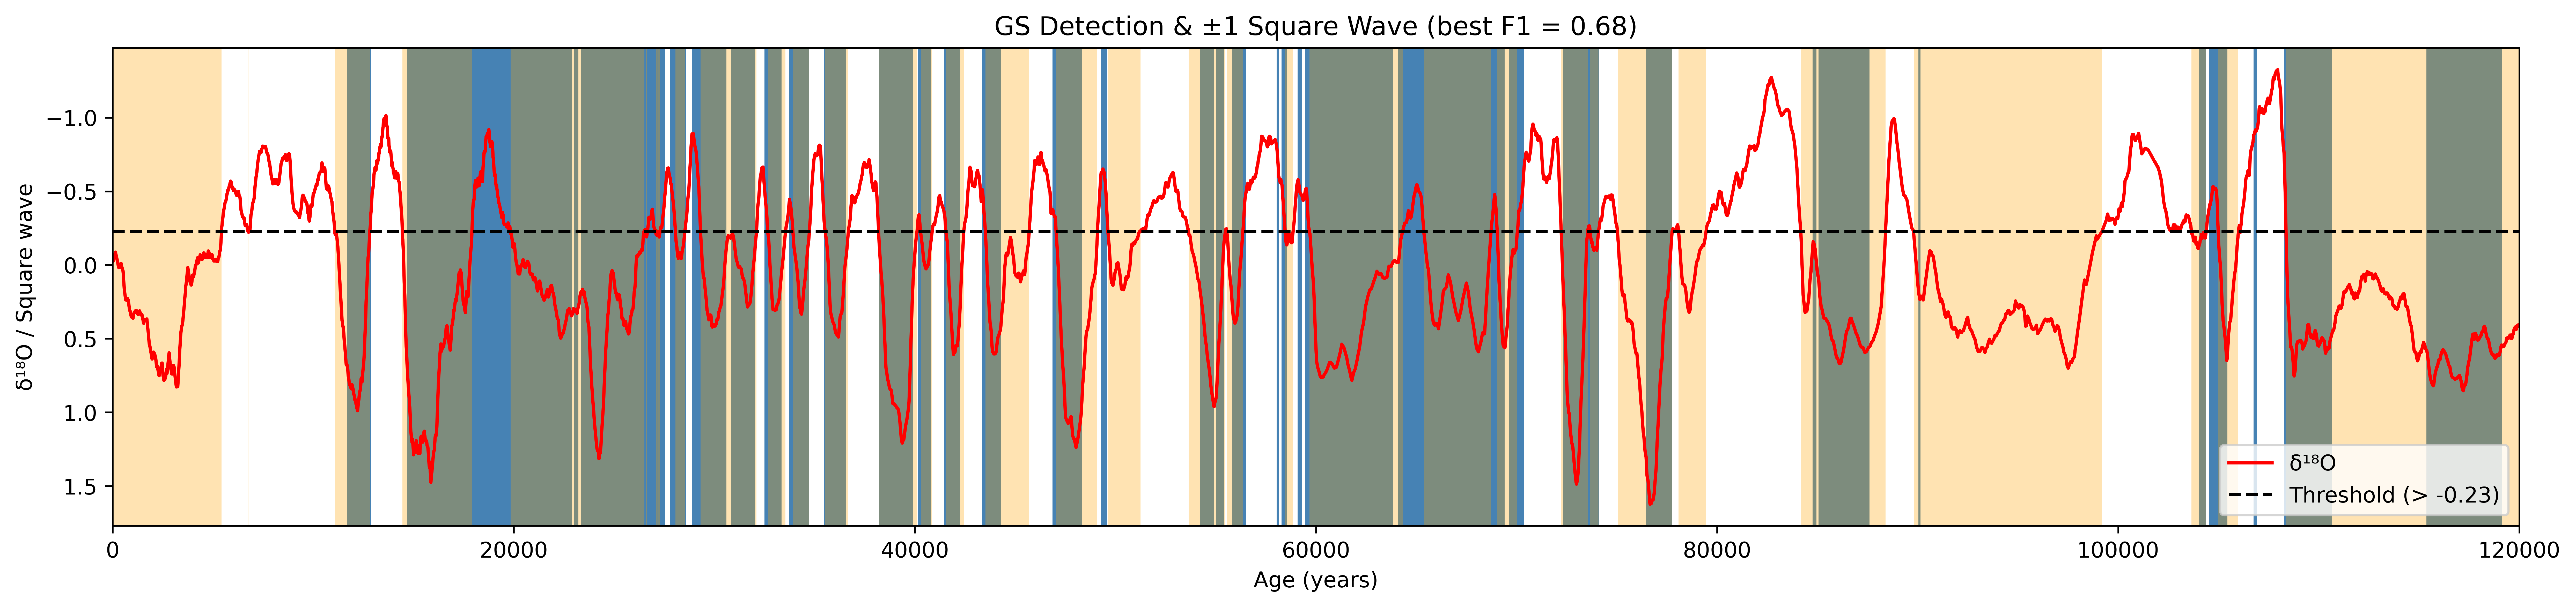

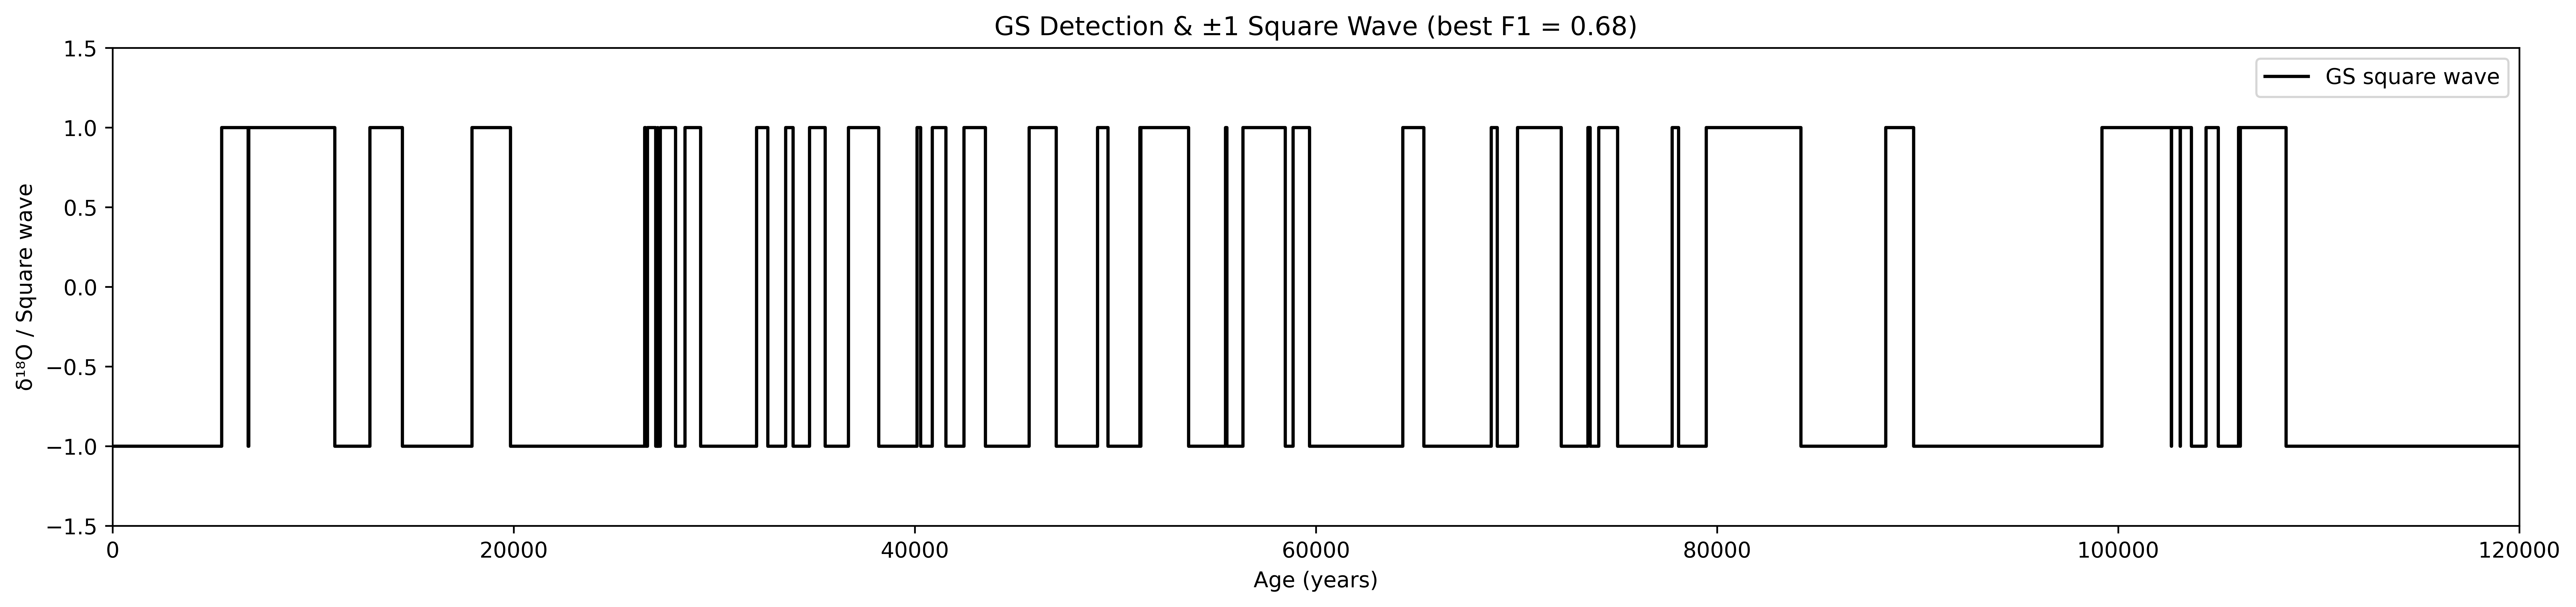

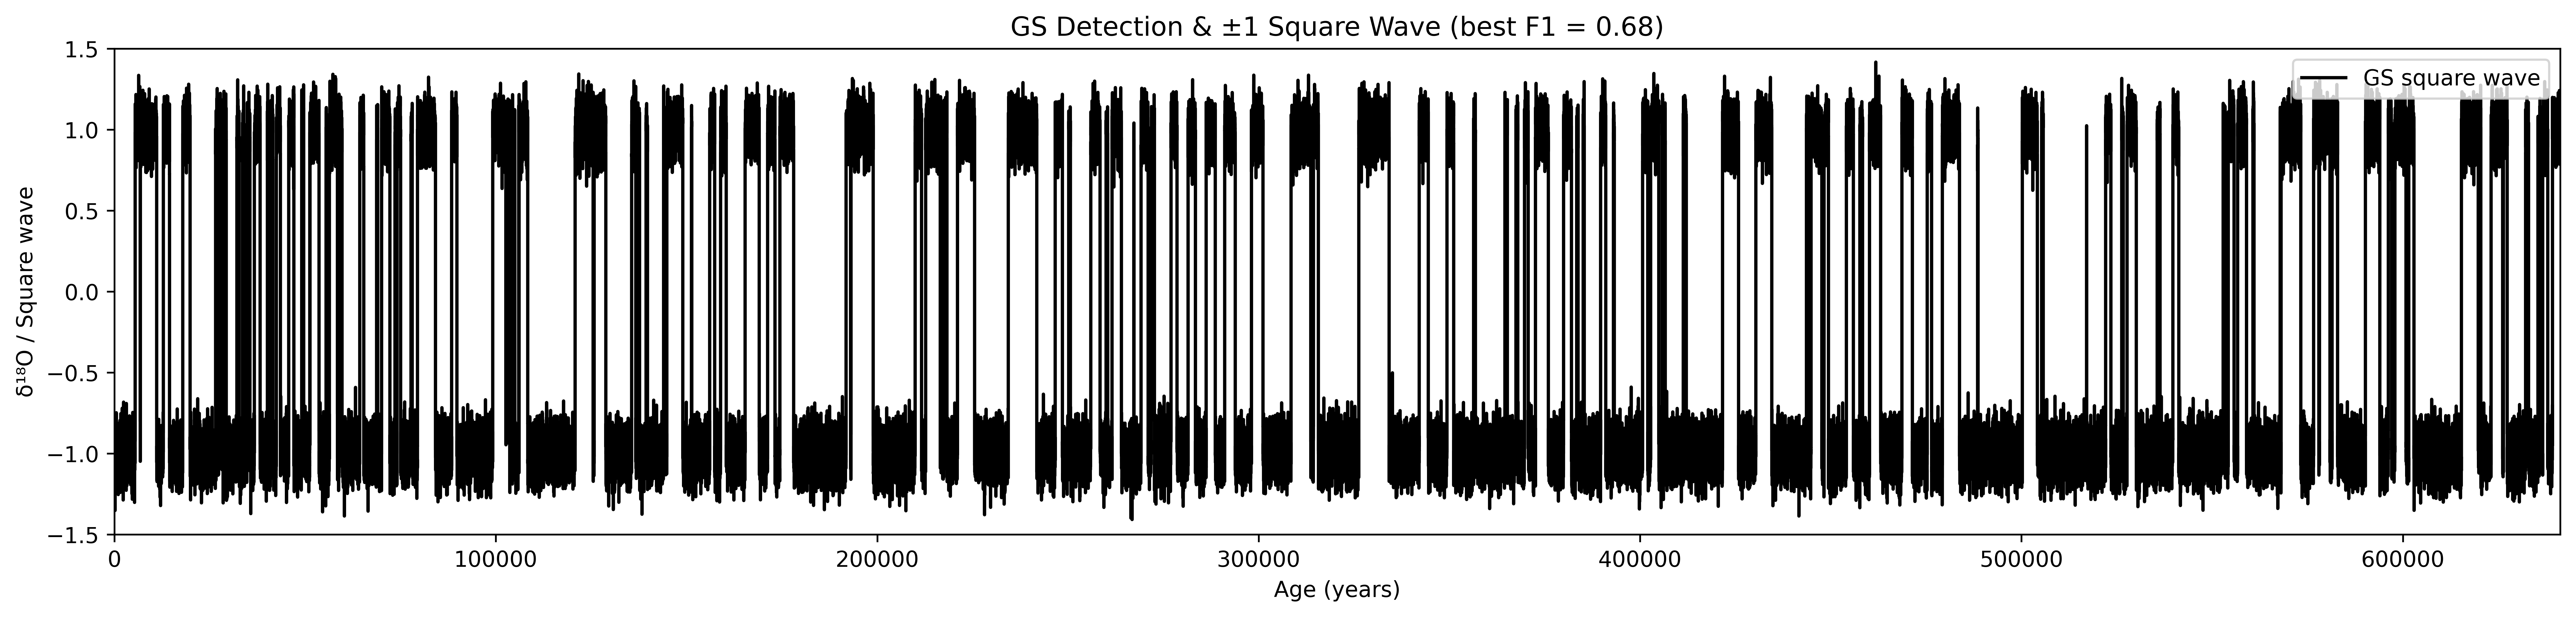

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import groupby

# ------------------------------------------------------------------
# 1.  YOUR GS TABLE  (unchanged)
# ------------------------------------------------------------------
data = {
    "event": ["GS-1", "GS-2.1c", "GS-2.2", "GS-3", "GS-4", "GS-5.1", "GS-5.2", "GS-6",
              "GS-7", "GS-8", "GS-9", "GS-10", "GS-11", "GS-12", "GS-13", "GS-14",
              "GS-15.1", "GS-15.2", "GS-16.1", "GS-16.2", "GS-17.1", "GS-17.2",
              "GS-18", "GS-19.1", "GS-19.2", "GS-20", "GS-21.1", "GS-21.2", "GS-22",
              "GS-23.1", "GS-23.2", "GS-24.1", "GS-24.2", "GS-25", "GS-26"],
    "start": [11703, 14692, 23020, 23340, 27780, 28900, 30840, 32500, 33740, 35480,
              38220, 40160, 41460, 43340, 46860, 49280, 54220, 55000, 55800, 58040,
              58280, 59080, 59440, 64100, 69620, 72340, 76440, 84760, 85060, 90040,
              104040, 104520, 106750, 108280, 115370],
    "end":   [12896, 22900, 23220, 27540, 28600, 30600, 32040, 33360, 34740, 36580,
              39900, 40800, 42240, 44280, 48340, 49600, 54900, 55400, 56500, 58160,
              58560, 59300, 63840, 69400, 70380, 74100, 77760, 84960, 87600, 90140,
              104380, 105440, 106900, 110640, 119140]
}

# ------------------------------------------------------------------
# 2.  Boolean "ground-truth" vector
# ------------------------------------------------------------------
# crop the df for data <120000 years
new_df_crop = new_df.copy()
new_df_crop = new_df_crop[new_df_crop['age'] < 120000]

ages = new_df_crop['age'].values
d18O  = new_df_crop['d18O'].values

ages_all = new_df['age'].values
d18O_all  = new_df['d18O'].values

is_gs_true = np.zeros_like(ages, dtype=bool)
for s, e in zip(data["start"], data["end"]):
    is_gs_true |= (ages >= s) & (ages <= e)

# ------------------------------------------------------------------
# 3.  Find best δ18O threshold (as before)
# ------------------------------------------------------------------
def f1(pred, true):
    tp = np.sum(pred & true)
    fp = np.sum(pred & ~true)
    fn = np.sum(~pred & true)
    return 2*tp / (2*tp + fp + fn) if (2*tp + fp + fn) else 0

cands = np.percentile(d18O, np.linspace(5, 95, 181))
best_thr, best_f1, best_dir = None, -1, None
for direction in ('gt','lt'):
    for thr in cands:
        pred = d18O > thr if direction=='gt' else d18O < thr
        score = f1(pred, is_gs_true)
        if score > best_f1:
            best_thr, best_f1, best_dir = thr, score, direction

# ------------------------------------------------------------------
# 4.  Build predicted GS mask & contiguous segments
# ------------------------------------------------------------------

# is_gs_pred = d18O > best_thr if best_dir=='gt' else d18O < best_thr
is_gs_pred = d18O_all > best_thr if best_dir=='gt' else d18O_all < best_thr

segments = []
for k, grp in groupby(enumerate(is_gs_pred), key=lambda x:x[1]):
    if k:
        grp = list(grp)
        segments.append((ages_all[grp[0][0]], ages_all[grp[-1][0]]))

print(f"Best threshold = {best_dir} {best_thr:.3f},  F1 = {best_f1:.2f}")

# ------------------------------------------------------------------
# 5.  Create the ±1 square wave: -1 inside GS, +1 outside
# ------------------------------------------------------------------
square_wave = np.where(is_gs_pred, -1, 1)

# ------------------------------------------------------------------
# 6.  Plot everything
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(20, 4), dpi=600)

# a) Official GS intervals
for s, e in zip(data["start"], data["end"]):
    ax.axvspan(s, e, color='steelblue', alpha=1, zorder=0, linewidth=0)

# b) Predicted GS intervals
for s, e in segments:
    ax.axvspan(s, e, color='orange', alpha=0.30, zorder=1, linewidth=0)

# c) δ18O curve
ax.plot(ages, d18O, color='red', label='δ¹⁸O', zorder=2)

# d) Horizontal threshold
ax.axhline(best_thr, color='k', linestyle='--',
           label=f"Threshold ({'>' if best_dir=='gt' else '<'} {best_thr:.2f})",
           zorder=3)

# # e) Square wave
# ax.plot(ages, square_wave, drawstyle='steps-post',
#         color='black', linewidth=1.5, label='GS square wave', zorder=4)

# # adjust y-limits so the square wave is clear
# ax.set_ylim(min(square_wave)-0.5, max(square_wave)+0.5)
# inverse the y-axis
ax.invert_yaxis()
# Cosmetics
ax.set_xlabel('Age (years)')
ax.set_ylabel('δ¹⁸O / Square wave')
ax.set_xlim(0, 120000)
ax.set_title(f"GS Detection & ±1 Square Wave (best F1 = {best_f1:.2f})")
# ax.grid(True)
ax.legend(loc='lower right')

plt.show()




fig, ax = plt.subplots(figsize=(20, 4), dpi=600)

# e) Square wave
ax.plot(ages_all, square_wave, drawstyle='steps-post',
        color='black', linewidth=1.5, label='GS square wave', zorder=4)

# adjust y-limits so the square wave is clear
ax.set_ylim(min(square_wave)-0.5, max(square_wave)+0.5)

# Cosmetics
ax.set_xlabel('Age (years)')
ax.set_ylabel('δ¹⁸O / Square wave')
ax.set_xlim(0, 120000)
ax.set_title(f"GS Detection & ±1 Square Wave (best F1 = {best_f1:.2f})")
# ax.grid(True)
ax.legend()

plt.show()






# create a new DataFrame for the square wave
df_sq = pd.DataFrame({'age': ages_all, 'sq': square_wave})

white_noise = np.random.normal(0, 0.1, len(square_wave))
df_sq['sq'] = df_sq['sq'] + white_noise




fig, ax = plt.subplots(figsize=(20, 4), dpi=600)
# e) Square wave
ax.plot(df_sq['age'], df_sq['sq'], drawstyle='steps-post',
        color='black', linewidth=1.5, label='GS square wave', zorder=4)

# adjust y-limits so the square wave is clear
ax.set_ylim(min(square_wave)-0.5, max(square_wave)+0.5)

# Cosmetics
ax.set_xlabel('Age (years)')
ax.set_ylabel('δ¹⁸O / Square wave')
# ax.set_xlim(0, 120000)
ax.set_title(f"GS Detection & ±1 Square Wave (best F1 = {best_f1:.2f})")
# ax.grid(True)
ax.legend(loc='upper right')
# set x lim
ax.set_xlim(0, 641260)

plt.show()



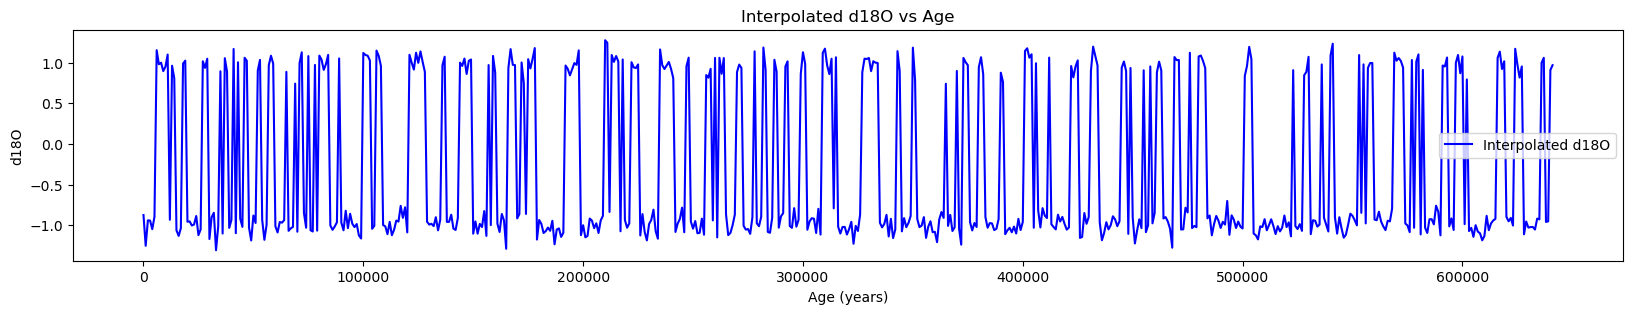

        age       pre
0         0  0.016280
1      1000  0.017116
2      2000  0.016308
3      3000  0.014018
4      4000  0.010453
..      ...       ...
637  637000  0.008929
638  638000  0.005100
639  639000  0.001432
640  640000 -0.001830
641  641000 -0.004658

[642 rows x 2 columns]


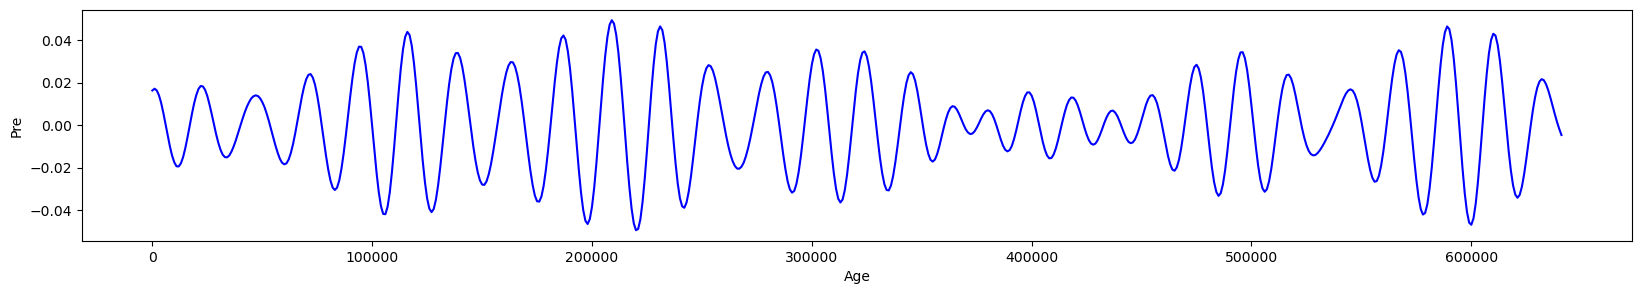

        age       obl
0         0  0.409093
1      1000  0.411353
2      2000  0.413555
3      3000  0.415639
4      4000  0.417555
..      ...       ...
637  637000  0.399430
638  638000  0.399004
639  639000  0.398819
640  640000  0.398878
641  641000  0.399176

[642 rows x 2 columns]


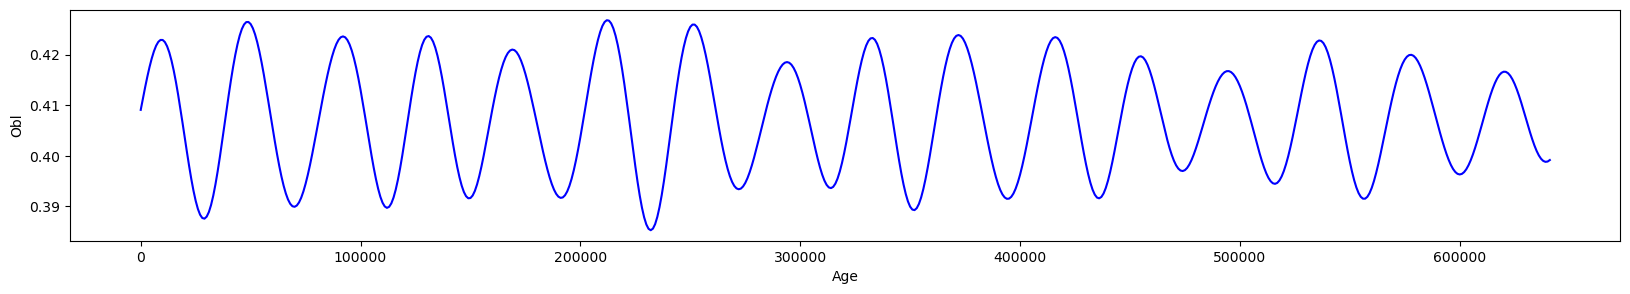

In [29]:
import pandas as pd
from scipy.interpolate import interp1d

# for df_sq, interpolated it to has 100 times lower resolution
new_age = np.arange(np.min(df_sq['age'].values), np.max(df_sq['age'].values), 1000)
# create a new DataFrame with the new age values
f_sq = interp1d(df_sq['age'], df_sq['sq'], kind='nearest',
             bounds_error=False,
             fill_value=1)
interpolated_sq = f_sq(new_age)
# create a new DataFrame with the new age values
df_sq = pd.DataFrame({'age': new_age, 'sq': interpolated_sq})
# plot the data
plt.figure(figsize=(20, 3))
plt.plot(df_sq['age'], df_sq['sq'], label='Interpolated d18O', color='blue')
plt.xlabel('Age (years)')
plt.ylabel('d18O')
plt.title('Interpolated d18O vs Age')
plt.legend()
plt.show()




# Read the file into a DataFrame
df_pre = pd.read_csv(
    r"D:\VScode\bipolar_seesaw_CCM\inso_data\pre_800.txt", 
    sep='\s+',       # '\s+' means "split on any whitespace"
    header=None,     # or specify a row number if there's a header
    engine='python'
)

df_obl = pd.read_csv(
    r"D:\VScode\bipolar_seesaw_CCM\inso_data\obl_800.txt", 
    sep='\s+',       # '\s+' means "split on any whitespace"
    header=None,     # or specify a row number if there's a header
    engine='python'
)

df_pre.iloc[:, 0] = df_pre.iloc[:, 0].abs() * 1000
df_obl.iloc[:, 0] = df_obl.iloc[:, 0].abs() * 1000

# Reverse the DataFrame rows
df_pre = df_pre.iloc[::-1]
df_pre.columns = ['age', 'pre']

df_obl = df_obl.iloc[::-1]
df_obl.columns = ['age', 'obl']


# interpolate the data using new_age
f = interp1d(df_pre['age'], df_pre['pre'], kind='nearest',
             bounds_error=False,
             fill_value=1)

interpolated_pre = f(new_age)
df_pre = pd.DataFrame({'age': new_age, 'pre': interpolated_pre})

f = interp1d(df_obl['age'], df_obl['obl'], kind='nearest',
             bounds_error=False,
             fill_value=1)

interpolated_obl = f(new_age)
df_obl = pd.DataFrame({'age': new_age, 'obl': interpolated_obl})

# plot df_pre
plt.figure(figsize=(20, 3))
plt.plot(df_pre.iloc[:, 0], df_pre.iloc[:, 1], label='pre', color='blue')
plt.xlabel("Age")
plt.ylabel("Pre")
print(df_pre)
plt.show()

plt.figure(figsize=(20, 3))
plt.plot(df_obl.iloc[:, 0], df_obl.iloc[:, 1], label='obl', color='blue')
plt.xlabel("Age")
plt.ylabel("Obl")
print(df_obl)
plt.show()

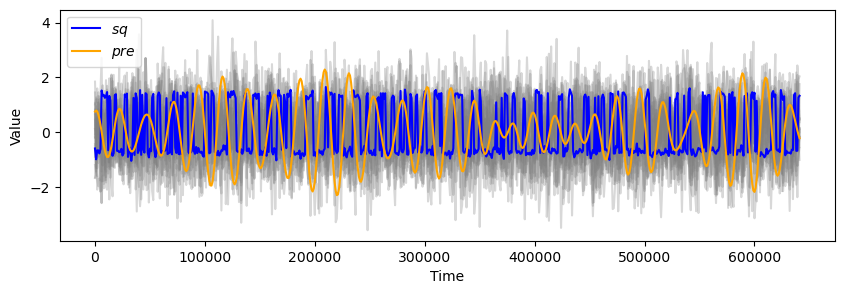

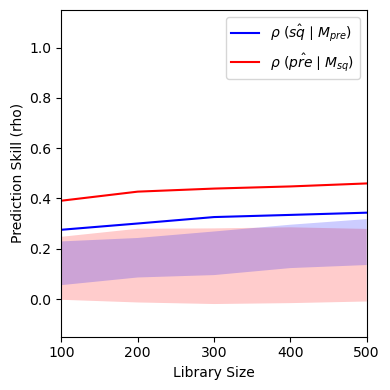

(True, True)


In [30]:
from toolbox import significant_test as st
import importlib
importlib.reload(st)



ccm_out, ran_ccm_list_xy, test_result=st.ccm_significance_test_v3(
    df_sq, 
    df_pre,
    E=6, 
    tau=-5, 
    n_ran=20, 
    libSizes="100 200 300 400 500",
    Tp=0,
    sample=20,
    random=True,
    uni_dir=False,
    showPlot=True)

print(test_result)

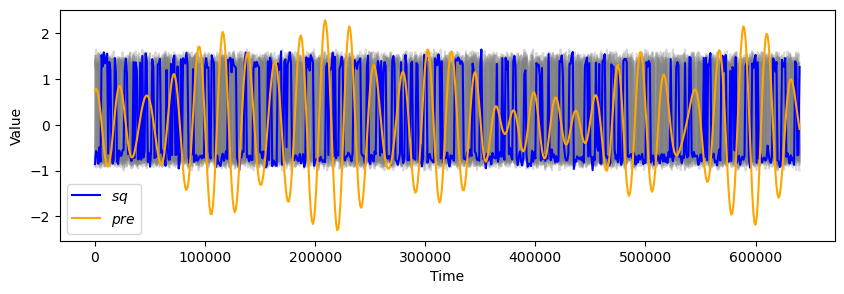

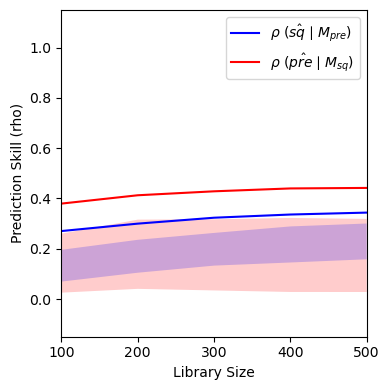

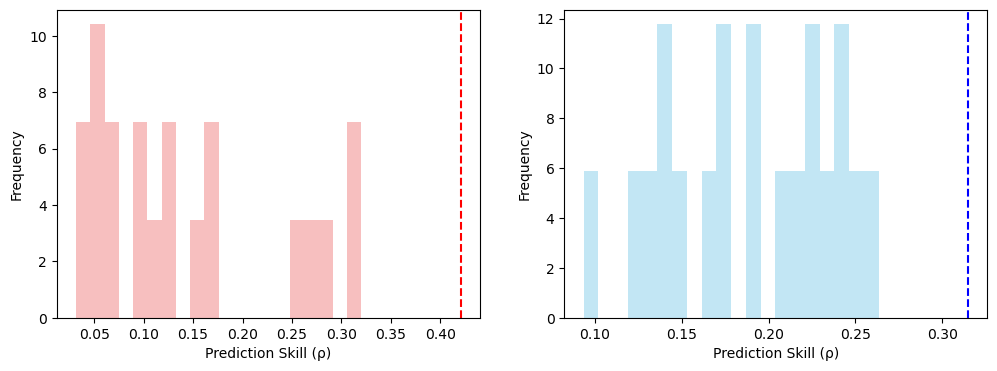

In [ ]:
from toolbox import significant_test as st
import importlib
importlib.reload(st)



ccm_out, ran_ccm_list_xy, test_result=st.ccm_significance_test_v2(
    df_sq, 
    df_pre,
    E=6, 
    tau=-5, 
    n_ran=20, 
    libSizes="100 200 300 400 500",
    Tp=0,
    sample=20,
    random=True,
    uni_dir=False,
    showPlot=True)

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import groupby

# ------------------------------------------------------------------
# 1.  YOUR GS TABLE  (unchanged – keep it exactly as you supplied)
# ------------------------------------------------------------------
data = {
    "event": ["GS-1", "GS-2.1c", "GS-2.2", "GS-3", "GS-4", "GS-5.1", "GS-5.2", "GS-6",
              "GS-7", "GS-8", "GS-9", "GS-10", "GS-11", "GS-12", "GS-13", "GS-14",
              "GS-15.1", "GS-15.2", "GS-16.1", "GS-16.2", "GS-17.1", "GS-17.2",
              "GS-18", "GS-19.1", "GS-19.2", "GS-20", "GS-21.1", "GS-21.2", "GS-22",
              "GS-23.1", "GS-23.2", "GS-24.1", "GS-24.2", "GS-25", "GS-26"],
    "start": [11703, 14692, 23020, 23340, 27780, 28900, 30840, 32500, 33740, 35480,
              38220, 40160, 41460, 43340, 46860, 49280, 54220, 55000, 55800, 58040,
              58280, 59080, 59440, 64100, 69620, 72340, 76440, 84760, 85060, 90040,
              104040, 104520, 106750, 108280, 115370],
    "end":   [12896, 22900, 23220, 27540, 28600, 30600, 32040, 33360, 34740, 36580,
              39900, 40800, 42240, 44280, 48340, 49600, 54900, 55400, 56500, 58160,
              58560, 59300, 63840, 69400, 70380, 74100, 77760, 84960, 87600, 90140,
              104380, 105440, 106900, 110640, 119140]
}

# ------------------------------------------------------------------
# 2.  Boolean "ground-truth" vector: 1⇔inside any GS interval, 0⇔otherwise
# ------------------------------------------------------------------
ages = new_df['age'].values
d18O = new_df['d18O'].values

is_gs_true = np.zeros_like(ages, dtype=bool)
for s, e in zip(data["start"], data["end"]):
    is_gs_true |= (ages >= s) & (ages <= e)          # element-wise “OR”

# ------------------------------------------------------------------
# 3.  Scan candidate thresholds and pick the one that maximises F1
#     • We try both directions (δ¹⁸O > y  *or*  δ¹⁸O < y)
# ------------------------------------------------------------------
def f1(pred, true):
    tp = np.sum(pred & true)
    fp = np.sum(pred & ~true)
    fn = np.sum(~pred & true)
    return 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) else 0.0

# Use a grid of percentiles as candidate cut-offs
cands = np.percentile(d18O, np.linspace(5, 95, 181))   # ≈0.5 % steps

best_thr, best_f1, best_dir = None, -1, None
for direction in ('gt', 'lt'):                         # greater-than OR less-than
    for thr in cands:
        pred = d18O > thr if direction == 'gt' else d18O < thr
        score = f1(pred, is_gs_true)
        if score > best_f1:
            best_thr, best_f1, best_dir = thr, score, direction

# ------------------------------------------------------------------
# 4.  Build contiguous predicted GS segments for plotting
# ------------------------------------------------------------------
is_gs_pred = d18O > best_thr if best_dir == 'gt' else d18O < best_thr

segments = []                                          # (start_age, end_age) pairs
for k, grp in groupby(enumerate(is_gs_pred), key=lambda x: x[1]):
    if k:                                              # only True segments
        grp = list(grp)
        segments.append((ages[grp[0][0]], ages[grp[-1][0]]))

print(f"Best threshold = {best_dir} {best_thr:.3f},  F1 = {best_f1:.2f}")

# ------------------------------------------------------------------
# 5.  Plot everything
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(20, 3), dpi=600)

# a) Official GS intervals (grey)
for s, e in zip(data["start"], data["end"]):
    ax.axvspan(s, e, color='grey', alpha=0.30, zorder=0, linewidth=0)

# b) Predicted GS intervals from δ¹⁸O (blue)
for s, e in segments:
    ax.axvspan(s, e, color='steelblue', alpha=0.30, zorder=1, linewidth=0)

# c) δ¹⁸O curve
ax.plot(ages, d18O, color='green', label='δ¹⁸O', zorder=2)

# d) Horizontal threshold
ax.axhline(best_thr, color='red', linestyle='--',
           label=f"Threshold ({'>' if best_dir=='gt' else '<'} {best_thr:.2f})", zorder=3)

# Cosmetic bits
ax.set_xlabel('Age (years)')
ax.set_ylabel('δ¹⁸O')
ax.set_xlim(0, 120000)
ax.set_title(f"Automatic GS Detection\nbest F1 = {best_f1:.2f}")
ax.grid(True)
ax.legend(loc='upper right')

plt.show()


Best threshold = gt 0.352,  F1 = 0.24


In [26]:
# for column d18O in new_df, find the quantiles that 0.35 corresponds to

quantile_0_35 = np.percentile(new_df['d18O'],80)
print(f"0.35 quantile of d18O: {quantile_0_35}")

0.35 quantile of d18O: 0.45055558476972235


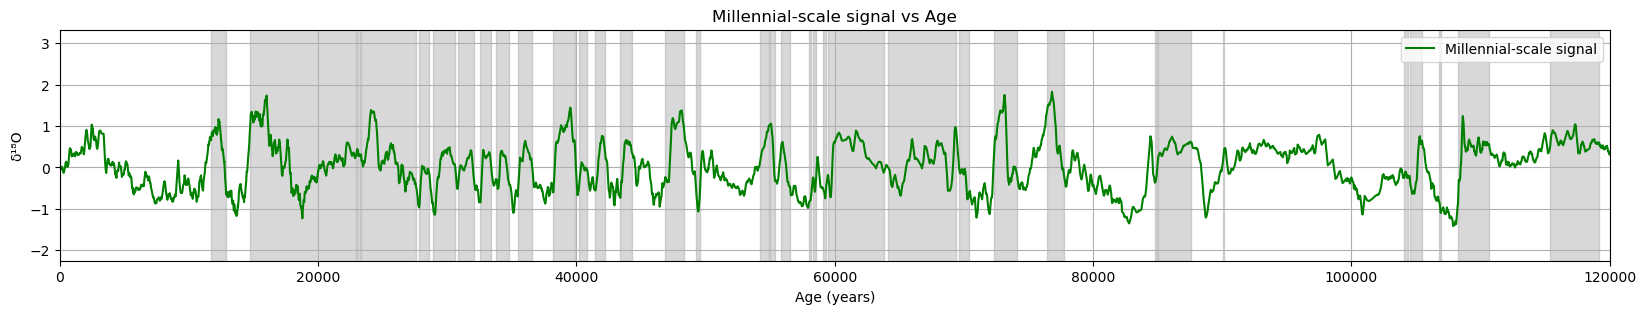

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


data = {
    "event": ["GS-1", "GS-2.1c", "GS-2.2", "GS-3", "GS-4", "GS-5.1", "GS-5.2", "GS-6", "GS-7", "GS-8",
              "GS-9", "GS-10", "GS-11", "GS-12", "GS-13", "GS-14", "GS-15.1", "GS-15.2", "GS-16.1", "GS-16.2",
              "GS-17.1", "GS-17.2", "GS-18", "GS-19.1", "GS-19.2", "GS-20", "GS-21.1", "GS-21.2", "GS-22",
              "GS-23.1", "GS-23.2", "GS-24.1", "GS-24.2", "GS-25", "GS-26"],
    # note: these are the *start* times of the GS events
    "start": [11703, 14692, 23020, 23340, 27780, 28900, 30840, 32500, 33740, 35480,
              38220, 40160, 41460, 43340, 46860, 49280, 54220, 55000, 55800, 58040,
              58280, 59080, 59440, 64100, 69620, 72340, 76440, 84760, 85060, 90040,
              104040, 104520, 106750, 108280, 115370],
    # and these are the *end* times
    "end":   [12896, 22900, 23220, 27540, 28600, 30600, 32040, 33360, 34740, 36580,
              39900, 40800, 42240, 44280, 48340, 49600, 54900, 55400, 56500, 58160,
              58560, 59300, 63840, 69400, 70380, 74100, 77760, 84960, 87600, 90140,
              104380, 105440, 106900, 110640, 119140]
}


# plot
plt.figure(figsize=(20, 3))

# add grey spans for each GS event
for s, e in zip(data["start"], data["end"]):
    plt.axvspan(s, e, color='grey', alpha=0.3)

# millennial-scale signal
plt.plot(new_df['age'], new_df['d18O'],
         label='Millennial‐scale signal', color='green')

plt.xlabel('Age (years)')
plt.ylabel('δ¹⁸O')
plt.title('Millennial‐scale signal vs Age')
plt.legend(loc='upper right')
plt.grid(True)
# reverse the y-axis
# plt.gca().invert_yaxis()
plt.xlim(0, 120000)

plt.show()

